# Waves on a discontinuous density mass (1D EVP)

El que vull fer és modificiar el codi anterior per representar la discontinuïtat de massa d'una corda en una dimensió. He d'emprar el codi que em va passar ramon per definir a trossos la corda.

exact_soln  [ 2.66901857  7.55178196  9.34725317 13.9452195  16.96084541]

2025-04-22 12:16:09,721 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 4s, Remaining: 0s, Rate: 2.7e-01/s
evals.size (before)  130
evals.size (after removing inf)  126
evals.size (after removing < 0)  126
First 5 True eigenvalues: [ 2.66901857  7.55178196  9.34725317 13.9452195  16.96084541]
First 5 Eigenvalues (sqrt): [ 2.62441261  7.53737967  9.29494714 13.71111477 16.94164751]
Relative error: [0.0167125  0.00190714 0.00559587 0.01678745 0.0011319 ]
Eigenvalues whose real eigenfunctions are plotted, real and imaginary parts
0109    +6.89e+00    -5.88e-13
0119    +5.68e+01    +2.40e-12
0110    +8.64e+01    -4.63e-13
0120    +1.88e+02    -1.48e-14
Eigenvalues whose imaginary eigenfunctions are plotted, real and imaginary parts
0109    +6.89e+00    -5.88e-13
0119    +5.68e+01    +2.40e-12
0110    +8.64e+01    -4.63e-13
0120    +1.88e+02    -1.48e-14


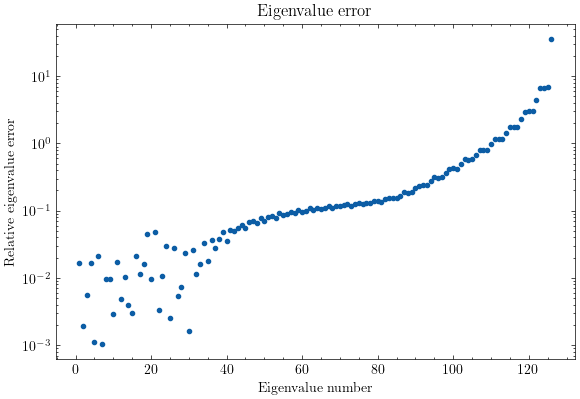

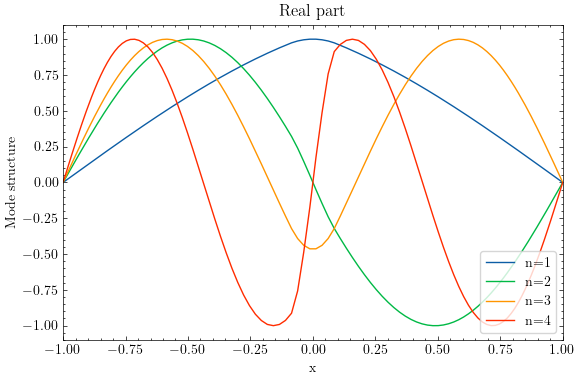

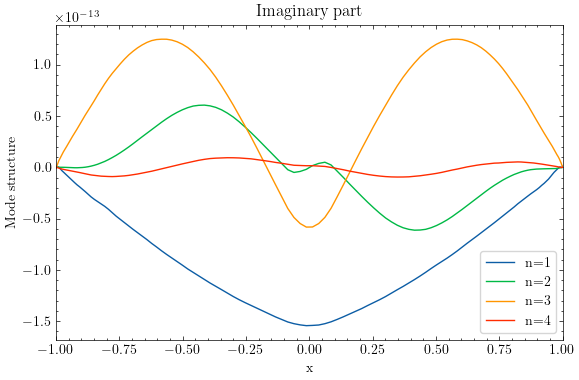

In [15]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)
import scienceplots
plt.style.use('science')

# Funcions den Monxo per calcular els autovalors exactes d'una corda amb densitat variable.
def dispersion_relation(omega):
    disprel_even = (np.sqrt(cp2)/np.sqrt(cc2)) * np.cos(omega * (xmax - xp) / np.sqrt(cc2)) * np.cos(omega * xp / np.sqrt(cp2)) - \
        np.sin(omega * (xmax - xp) / np.sqrt(cc2)) * np.sin(omega * xp / np.sqrt(cp2))
    disprel_odd = (np.sqrt(cp2)/np.sqrt(cc2)) * np.cos(omega * (xmax - xp) / np.sqrt(cc2)) * np.sin(omega * xp / np.sqrt(cp2)) + \
        np.sin(omega * (xmax - xp) / np.sqrt(cc2)) * np.cos(omega * xp / np.sqrt(cp2))
    disprel = disprel_even * disprel_odd
    return disprel

def get_eigenvalues(Nevals):
    Nsol = 0
    omega0 = 1
    omega_step = 0.5
    exact_soln = np.array([])
    while Nsol < Nevals:
        sol = fsolve(dispersion_relation, omega0)
#         print('omega0, sol ', omega0, sol)
        if sol > 0:
            exact_soln = np.append(exact_soln, sol)
            exact_soln = np.unique(exact_soln.round(decimals=8))
#         print('exact_soln, exact_soln**2 ', exact_soln, exact_soln**2)
#         print(exact_soln.size)
        Nsol = exact_soln.size
        omega0 = omega0 + omega_step
    print('exact_soln ', exact_soln[0:5])
#    print('exact_soln**2 ', exact_soln**2)
    print()
    return exact_soln


# Parameters
Nx = 128
dtype = np.complex128

# Límits
xmax = 1
xmin = -1
# Position of boundaries between different parts of the system (prominence and corona).
xp = 0.1
# xc ∈ [-1, -0.1], xc ∈ [0.1, 1]
# Square of the wave velocity in the two parts of the system.
cp2 = 1
cc2 = 6

# Bases
xcoord = d3.Coordinate('x')
dist = d3.Distributor(xcoord, dtype=dtype)
#xbasis = d3.Legendre(xcoord, size=Nx, bounds=(0, Lx)) # Amb Chebyshev crec que l'error oscil·la manco
basis = d3.Legendre(xcoord, size=Nx, bounds=(-xmax, xmax)) # Definim una base amb uns altres límits

# Fields
u = dist.Field(name='u', bases=basis) # u = eigenfunction
tau_1 = dist.Field(name='tau_1')
tau_2 = dist.Field(name='tau_2')
s = dist.Field(name='s') # s = eigenvalue
# Nous camps
x = dist.local_grid(basis)
c2 = dist.Field(name='c2', bases=basis) # c2 = velocity squared
c2['g'] = np.piecewise(x, [x < -xp, (-xp <= x) * (x <= xp), x > xp], [cc2, cp2, cc2]) # Representa la c^2 en l'espai real ('g') a trossos.


# Substitutions
dx = lambda A: d3.Differentiate(A, xcoord)
lift_basis = basis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)
ux = dx(u) + lift(tau_1) # First-order reduction
uxx = dx(ux) + lift(tau_2) # Second-order reduction


# Problem
problem = d3.EVP([u, tau_1, tau_2], eigenvalue=s, namespace=locals())
problem.add_equation("s*u + c2 * uxx = 0")
problem.add_equation("u(x=-xmax) = 0")
problem.add_equation("u(x=xmax) = 0")

# Autovalors exactes
# Get the first (i.e. positive) Nevals eigenvalues.
Nevals = np.rint(Nx*1.2).astype(int)
exact_soln = get_eigenvalues(Nevals)

# Solve
solver = problem.build_solver()
solver.solve_dense(solver.subproblems[0])
evals = np.sort(solver.eigenvalues)

print('evals.size (before) ', evals.size)
evals = evals[~np.isinf(evals)] # el ~ és un operador bitwise NOT, que retorna True si el valor és False i viceversa. En aquest cas elimina els valors infinits
print('evals.size (after removing inf) ', evals.size)
evals = evals[evals > 0] # eliminam els valors negatius
print('evals.size (after removing < 0) ', evals.size)
evals = np.sqrt(evals)

n = 1 + np.arange(evals.size)
# true_evals = (n * np.pi / 2*xmax)**2 # vàlid per densitat constant
true_evals = exact_soln[0:evals.size]
relative_error = np.abs(evals - true_evals) / true_evals

# Agafam la part real per fer un print més net
evals = evals.real
print("First 5 True eigenvalues:", true_evals[:5])
print("First 5 Eigenvalues (sqrt):", evals[:5])
print("Relative error:", relative_error[:5])



# Plot error
plt.figure(figsize=(6, 4))
plt.semilogy(n, relative_error, '.')
plt.xlabel("Eigenvalue number")
plt.ylabel("Relative eigenvalue error")
plt.tight_layout()
plt.title("Eigenvalue error")
#plt.savefig("eigenvalue_error.pdf")
#plt.savefig("eigenvalue_error.png", dpi=200)
 
# Plot real part
plt.figure(figsize=(6, 4))
x = dist.local_grid(basis)
print("Eigenvalues whose real eigenfunctions are plotted, real and imaginary parts")
for n, idx in enumerate(np.argsort(solver.eigenvalues)[:4], start=1):
   if solver.eigenvalues[idx].real > 0:
        print(f"{idx:04d}    {solver.eigenvalues[idx].real:+.2e}    {solver.eigenvalues[idx].imag:+.2e}")

   solver.set_state(idx, solver.subsystems[0])
   ug = (u['g']).real / (u['g'][1]).real
   plt.plot(x, ug/np.max(np.abs(ug)), label=f"n={n}")
plt.xlim(xmin, xmax)
plt.legend(loc="lower right", frameon=True)
plt.ylabel(r"Mode structure")
plt.xlabel(r"x")
plt.title("Real part")
plt.tight_layout()
#plt.savefig("eigenvectors.pdf")
#plt.savefig("eigenvectors.png", dpi=200)

# Plot imag part
plt.figure(figsize=(6, 4))
x = dist.local_grid(basis)
print("Eigenvalues whose imaginary eigenfunctions are plotted, real and imaginary parts")
for n, idx in enumerate(np.argsort(solver.eigenvalues)[:4], start=1):
    solver.set_state(idx, solver.subsystems[0])
    if solver.eigenvalues[idx].real > 0:
        print(f"{idx:04d}    {solver.eigenvalues[idx].real:+.2e}    {solver.eigenvalues[idx].imag:+.2e}")

    # ens interessa part Im per comprovar que està bé; ha de ser nul·la
    ug = (u['g'] / u['g'][1]).real
    ui = (u['g'] / u['g'][1]).imag
    plt.plot(x, ui/np.max(np.abs(ug)), label=f"n={n}") # no normalitzam pq ens divideix per 0 ### ara sí normalitzam
plt.xlim(xmin, xmax)
plt.legend(loc="lower right", frameon=True)
plt.ylabel(r"Mode structure")
plt.xlabel(r"x")
plt.title("Imaginary part")
plt.tight_layout()
#plt.savefig("eigenvectors.pdf")
#plt.savefig("eigenvectors.png", dpi=200)



# És útil mirar directament els autovalors (ojo arrel!!!) i comprovar que la part imaginària és quasi nul·la; no creix en amplitud
#for i, eigenvalue in enumerate(evals):
#    print(f"Eigenvalue {i+1}: {eigenvalue}") # si els volem veure tots 126...
#   if i < 5:
#       print(f"Eigenvalue = {i+1}, s = {eigenvalue}")
#   if i > len(evals)-6:
#       print(f"Eigenvalue = {i+1}, s = {eigenvalue}")
        
